/tmp/ipykernel_28660/2959653271.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')


Total Fe patches found: 984
Processing image 1: fe_patches/patch_Fe_151x151_xy(12,14).png
Processing image 2: fe_patches/patch_Fe_151x151_xy(10,29).png
Processing image 3: fe_patches/patch_Fe_151x151_xy(271,51).png
Processing image 4: fe_patches/patch_Fe_151x151_xy(465,18).png
Processing image 5: fe_patches/patch_Fe_151x151_xy(253,7).png
Processing image 6: fe_patches/patch_Fe_151x151_xy(275,42).png
Processing image 7: fe_patches/patch_Fe_151x151_xy(206,38).png
Processing image 8: fe_patches/patch_Fe_151x151_xy(483,40).png
Processing image 9: fe_patches/patch_Fe_151x151_xy(117,21).png
Processing image 10: fe_patches/patch_Fe_151x151_xy(459,45).png


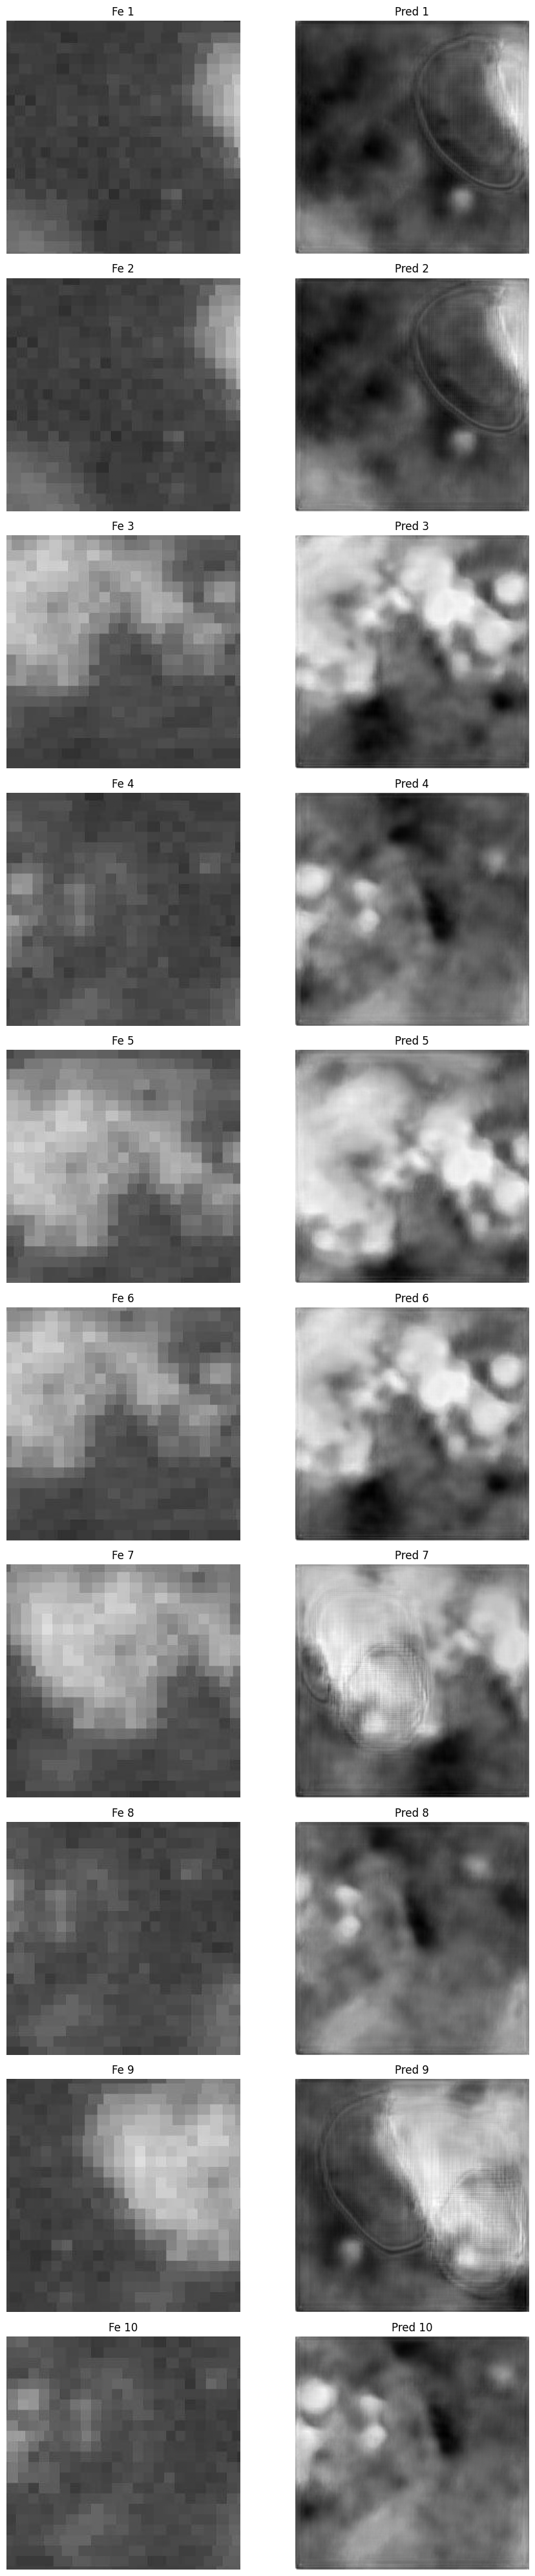

In [14]:
import torch
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the same model architecture as in training
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", 
    in_channels=3,
    classes=3,
).to(device)

# Load the trained model weights
checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load and preprocess a test image
transform = transforms.Compose([
    transforms.ToTensor()
])

# Get list of Fe images and take first 10
fe_images = glob('fe_patches/patch_Fe_151x151_xy(*).png')
print(f"Total Fe patches found: {len(fe_images)}")

# Plot first 10 images and their predictions
plt.figure(figsize=(10, 40))
for i, test_image_path in enumerate(fe_images[:10]):
    print(f"Processing image {i+1}: {test_image_path}")
    
    # Load and process image
    test_image = Image.open(test_image_path).convert('RGB')
    test_tensor = transform(test_image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        predicted = model(test_tensor)
    
    # Convert tensors to images
    test_np = test_tensor.squeeze().cpu().permute(1,2,0).numpy()
    pred_np = 1 - predicted.squeeze().cpu().permute(1,2,0).numpy()
    # Convert prediction to grayscale by averaging channels
    pred_np_gray = np.mean(pred_np, axis=2)
    
    # Plot original
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(test_np)
    plt.title(f'Fe {i+1}')
    plt.axis('off')
    
    # Plot prediction in grayscale
    plt.subplot(10, 2, 2*i+2)
    plt.imshow(pred_np_gray, cmap='gray')
    plt.title(f'Pred {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
import os
from glob import glob
from PIL import Image
import numpy as np
from tqdm import tqdm

# Create output directory if it doesn't exist
output_dir = 'output_patches'
os.makedirs(output_dir, exist_ok=True)

# Get all Fe patch images
fe_patches = glob('fe_patches/patch_Fe_151x151_xy(*).png')

# Process each patch
for fe_path in tqdm(fe_patches, desc="Processing patches"):
    # Load and process the Fe image
    test_image = Image.open(fe_path).convert('RGB')
    test_tensor = transform(test_image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        predicted = model(test_tensor)
    
    # Convert to numpy and invert
    pred_np = 1 - predicted.squeeze().cpu().permute(1,2,0).numpy()
    
    # Get coordinates from filename
    coords = os.path.basename(fe_path).split('_')[-1].replace('.png','')
    
    # Save predicted image
    pred_img = Image.fromarray((pred_np * 255).astype(np.uint8))
    output_path = os.path.join(output_dir, f'pred_Req_15x15_{coords}.png')
    pred_img.save(output_path)

print(f"Saved {len(fe_patches)} predicted patches to {output_dir}")

# Now stitch the patches together
# First get the coordinates to determine image dimensions
coords_list = []
print("Collecting coordinates...")
for path in tqdm(fe_patches, desc="Getting coordinates"):
    coords = os.path.basename(path).split('_')[-1].replace('.png','').strip('()').split(',')
    coords = [int(c) for c in coords]
    coords_list.append(coords)

# Find dimensions of final image
max_x = max(c[0] for c in coords_list) + 1
max_y = max(c[1] for c in coords_list) + 1

# Create blank image
patch_size = 15  # Size of Req patches
final_image = np.zeros((max_y * patch_size, max_x * patch_size, 3), dtype=np.uint8)

# Place each patch in the correct position
print("Stitching patches...")
for coords in tqdm(coords_list, desc="Stitching patches"):
    x, y = coords
    patch_path = os.path.join(output_dir, f'pred_Req_15x15_({x},{y}).png')
    if os.path.exists(patch_path):
        patch = np.array(Image.open(patch_path))
        final_image[y*patch_size:(y+1)*patch_size, 
                   x*patch_size:(x+1)*patch_size] = patch

# Save stitched image
stitched_image = Image.fromarray(final_image)
stitched_image.save(os.path.join(output_dir, 'stitched_prediction.png'))

# Display the stitched image
plt.figure(figsize=(15,15))
plt.imshow(stitched_image)
plt.axis('off')
plt.title('Stitched Prediction')
plt.show()

print(f"Saved stitched prediction image of size {final_image.shape}")


Processing patches: 100%|██████████| 984/984 [01:22<00:00, 11.90it/s]


Saved 984 predicted patches to output_patches


Getting coordinates:   0%|          | 0/984 [00:00<?, ?it/s]


ValueError: invalid literal for int() with base 10: 'xy(12'